<a href="https://colab.research.google.com/github/VMBoehm/ML-Tutorials/blob/master/VAE%2BPCA_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VAE+PCA Tutorial.**
## **Implements and compares different data compression methods (Principal Component Analysis and Variational AutoEncoder)**

### **Copyright (C) 2019  Vanessa Boehm**

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
   
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.



In [53]:
# comment out if you are not running this on google colab
from google.colab import drive

ROOT = "/content/gdrive"

drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [54]:
%pylab inline
import pickle as pkl
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cov', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Let's first download the mnist dataset (http://yann.lecun.com/exdb/mnist/) and inspect it a little

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch

def _download_mnist(dataset):
    """
    download mnist dataset if not present
    """
    origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
    print('Downloading data from %s' %origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    """
    returns data path
    """
    #where am I? return full path
    full_path = os.path.abspath('./')
    path = full_path +'/data'
    return path


def load_mnist():
    """
    load mnist dataset
    """

    dataset=_get_datafolder_path()+'/mnist/mnist.pkl.gz'

    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            print('creating ', datasetfolder)
            os.makedirs(datasetfolder)
        _download_mnist(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    #omitting validation set 
    return x_train, targets_train, x_test, targets_test

In [50]:
x_train, targets_train, x_test, targets_test  = load_mnist()

print('size of training and test datasets', x_train.shape[0], x_test.shape[0])
print('number of examples per label:')
for ii in range(10):
  print('label %d:'%ii, len(np.where(targets_train==ii)[0]))

size of training and test datasets 50000 10000
number of examples per label:
label 0: 4932
label 1: 5678
label 2: 4968
label 3: 5101
label 4: 4859
label 5: 4506
label 6: 4951
label 7: 5175
label 8: 4842
label 9: 4988


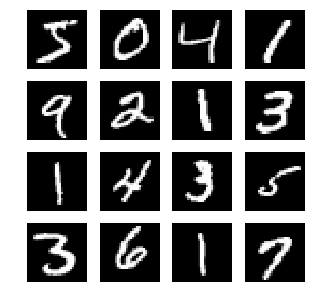

In [51]:
figure(figsize=(5,5))
for ii in range(16):
  subplot(4,4,ii+1)
  imshow(x_train[ii].reshape(28,28),cmap='gray')
  axis('off')

### Next step is a 'traditional' principal component analysis for dimenensionality reduction

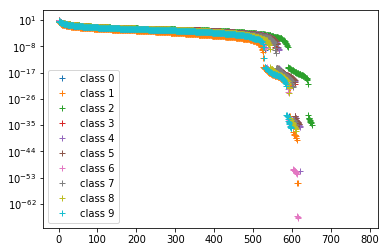

In [52]:
# compute the data covariance by class and decompose 
from sklearn.covariance import EmpiricalCovariance #more memory efficient than by hand...

ws = np.zeros((10,28*28))
vs = np.zeros((10,28*28,28*28))

figure()
for ii in range(10):
  
  # compute covariance 
  indices       = np.where(targets_train==ii)
  x             = x_train[indices]
  cov           = EmpiricalCovariance(assume_centered=False).fit(x).covariance_

  #decompose
  w,v           = np.linalg.eigh(cov)
  
  #order by size and store
  indices       = np.argsort(w)[::-1]
  w             = w[indices]
  ws[ii] = w
  vs[ii] = v.T[indices]

  #plot
  semilogy(np.arange(len(w)),w, ls='', marker='+', label='class %d'%ii)
legend()
show()

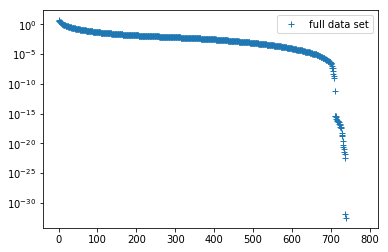

In [58]:
# and on the full data set
  
# compute covariance 

x             = x_train
cov           = EmpiricalCovariance(assume_centered=False).fit(x).covariance_

#decompose
w,v           = np.linalg.eigh(cov)

#order by size and store
indices       = np.argsort(w)[::-1]
w             = w[indices]
v             = v.T[indices]

#plot
semilogy(np.arange(len(w)),w, ls='', marker='+', label='full data set')
legend()
show()

#### compress and reconstruct some data



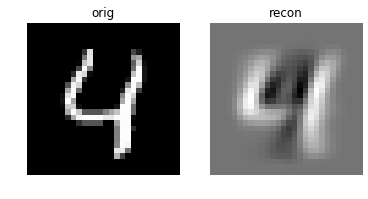

rms-difference: 0.223352008961925


In [55]:
# which digit to look at
label      = 4
# dimensionality of compressed space
latent_dim = 2

# restrict compression operator to desired dimensionality
R = vs[label][:latent_dim]

# restrict test data to label
x = x_test[np.where(targets_test==label)][0]

#compression
s = np.dot(R,x)

#decompression
x_hat = np.dot(R.T,s)

figure()
subplot(1,2,1)
title('orig')
imshow(x.reshape(28,28),cmap='gray')
axis('off')
subplot(1,2,2)
title('recon')
imshow(x_hat.reshape(28,28), cmap='gray')
axis('off')
show()

print('rms-difference:', np.sqrt(np.mean((x_hat-x)**2)))

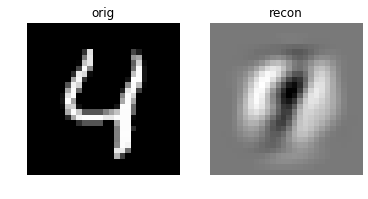

rms-difference: 0.22402108918571023


In [59]:
# same thing with PCA 'trained' on entire dataset
R = v[:latent_dim]

# restrict test data to label
x = x_test[np.where(targets_test==label)][0]

#compression
s = np.dot(R,x)

#decompression
x_hat = np.dot(R.T,s)

figure()
subplot(1,2,1)
title('orig')
imshow(x.reshape(28,28),cmap='gray')
axis('off')
subplot(1,2,2)
title('recon')
imshow(x_hat.reshape(28,28), cmap='gray')
axis('off')
show()

print('rms-difference:', np.sqrt(np.mean((x_hat-x)**2)))

**Now, let's turn to non-linear PCA aka a VAE**

In [0]:
# pretrained VAE (training from scratch would take too long)
decoder_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'

In [0]:
#import tensorflow modules
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions

In [0]:
latent_dim = 8
data_size  = 1
data_dim   = 28*28
n_channels = 1
label      = 4

In [0]:
# these are the two functions that were used in the loss function (ELBO) to train the encoder and decoder

def likelihood(z,sigma, encoder):
  mean = decoder(z)#decoder({'z':z},as_dict=True)['x']
  return tfd.Independent(tfd.MultivariateNormalDiag(loc=mean,scale_identity_multiplier=sigma))

def approx_posterior(x,decoder):
  mu, sig          = tf.split(encoder(x), 2, axis=-1)#tf.split(encoder({'x':x},as_dict=True)['z'], 2, axis=-1)
  sig              = tf.nn.softplus(sig) + 0.0001
  approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sig)
  return approx_posterior

In [0]:
# (build) the model
tf.reset_default_graph()

decoder = hub.Module(decoder_path, trainable=False)
encoder = hub.Module(encoder_path, trainable=False)

sigma = tf.placeholder_with_default(0.1,shape=[])

x     = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)

x_    = tf.reshape(x,(data_size,28,28,n_channels))
s     = approx_posterior(x_,encoder).mean()

x_hat = likelihood(s,sigma,decoder).mean()



In [0]:
# initialize and run the model
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# restrict test data to label
input_data = x_test[np.where(targets_test==label)][0].reshape((data_size,data_dim,n_channels))

recon_data = sess.run(x_hat, feed_dict={x:input_data})

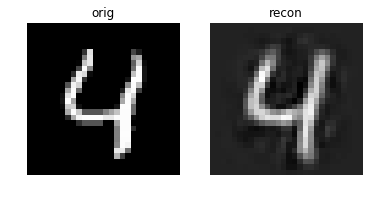

rms-difference: 0.3588921


In [66]:
#Let's have a look at the reconstructions
figure()
subplot(1,2,1)
title('orig')
imshow(input_data.reshape(28,28),cmap='gray')
axis('off')
subplot(1,2,2)
title('recon')
imshow(recon_data.reshape(28,28), cmap='gray')
axis('off')
show()


print('rms-difference:', np.sqrt(np.mean((recon_data.flatten()-input_data)**2)))

((1, 784, 1), (1, 28, 28, 1))